## Proyecto Final asignatura AIA
Con este notebook pretendo mostrar de una manera resumida los conociemientos adquiridos en la asignatura Ampliación de Inteligencia Artificial, asignatura cursada en tercero de Ingeniería Informática-Tecnologías Informáticas en la Universidad de Sevilla.

Con este notebook busco mostrar mi dominio, sobre todo, a la hora de progrmar e implementar, no obstante, en el trabajo original se realizan ciertas explicaciones teóricas sobre, por ejemplo el calculo de parametros de una red.
Estas explicaciones no serán incluidas en este notebook.

Este trabajo en concreto se evaluó con una calificación de 9/10.

# Carga de datos.
Este código venía ya proporcionado por los profesores, por lo que, en este notebook no le daré mayor importancia a esta parte. Además, adjuntaré el trabajo orginal donde vienen explicado el dataset, funciones, enunciados, etc...

Como he dicho, en este notebook resumiré todo esto.

En primer lugar usaremos el dataset de TensorFlow de Flowers, este dataset no nos ofrece una estructura de train y val, simplemente la estructura de clases. El dataset cuenta con 5 tipos de flores.



In [17]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import pathlib
import os
import glob
import shutil
tf.__version__

'2.12.0'

In [18]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="flower_photos.tgz",
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

Con estas líneas de código el directorio quedaría de la siguiente manera:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

Nosotros moveremos las imágenes de forma que se vaya el 80% a train y el 20% a val. Quedando así de la siguiente forma el directorio:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [12.jpg, 28.jpg, 31.jpg ....]
    |______ <b>dandelion</b>: [41.jpg, 22.jpg, 35.jpg ....]
    |______ <b>roses</b>: [121.jpg, 92.jpg, 38.jpg ....]
    |______ <b>sunflowers</b>: [93.jpg, 23.jpg, 83.jpg ....]
    |______ <b>tulips</b>: [109.jpg, 267.jpg, 93.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>

In [19]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [20]:
SPLIT_RATIO=0.8

for cl in classes:
    # path de las imagenes de la clase cl
    img_path = os.path.join(base_dir, cl)

    # obtenemos la lista de todas las imagenes
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Imagenes".format(cl, len(images)))

    # determinamos cuantas imagenes son el 80%
    num_train = int(round(len(images)*SPLIT_RATIO))

    # separamos las imagenes en dos listas
    train, val = images[:num_train], images[num_train:]

    # creamos la carpeta de train/clase y val/clase
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))

    # movemos las imagenes
    for t in train:
        shutil.move(t, os.path.join(base_dir, 'train', cl))
    for v in val:
        shutil.move(v, os.path.join(base_dir, 'val', cl))

roses: 641 Imagenes


Error: ignored

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

daisy_dir = os.path.join(train_dir, 'daisy')
dandelion_dir = os.path.join(train_dir, 'dandelion')
roses_dir = os.path.join(train_dir, 'roses')
sunflowers_dir = os.path.join(train_dir, 'sunflowers')
tulips_dir = os.path.join(train_dir, 'tulips')

# Visualización del dataset. (A partir de aquí es código propio)

Visualizaremos 3 imágenes de cada clase, utilizando como título de la imagen, el shape del array de numpy asociado a cada imagen.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

clases = [daisy_dir, dandelion_dir, roses_dir, sunflowers_dir, tulips_dir]

plt.figure(figsize=(16,12))
for i,clase in enumerate(clases):
  for j,img in enumerate(os.listdir(clase)[:3]):
    img_path = os.path.join(clase, img)
    sp = plt.subplot(5, 3, i * 3 + j + 1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.title(img.shape)
    plt.imshow(img)

##Modelo 1: CNN básica (objetivo: accuracy_valid > 60%)

Con este modela empezaremos creando una red básica en base a unos requisitos dados. Estos requisitos fueron los siguientes:

Bloque de procesamiento de imagen:
1.   32 kernels -> 64 kernels -> 96 kernels
2.   kernels de 3x3.
3.   Stride = 1 y padding = SI.
4.   Función de activación ReLU.
5.   Maxpooling de 2x2 con stride clásico de 2 pixeles.
6.   Igualamos el tamaño de todas las imágenes a 150 x 150.

Bloque de decisión:
7.   Capa densa de 512 neuronas.
8.   Capa densa de salida.

Para estos requisitos implementé la siguiente red:

In [21]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape=(150,150,3), padding = 'same',
                              activation = 'relu', name = 'Conv1'))
model.add(keras.layers.MaxPooling2D(strides=(2,2)))

model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'Conv2'))
model.add(keras.layers.MaxPooling2D(strides=(2,2)))

model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'Conv3'))
model.add(keras.layers.MaxPooling2D(strides=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dense(units=5, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 Conv3 (Conv2D)              (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 18, 18, 96)      

In [23]:
optim = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

Reescalamos las imagenes con los generadores.

In [24]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=100,
                                                    class_mode='sparse')
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(150,150),
                                                    batch_size=100,
                                                    class_mode='sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [26]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
30/30 [==============================] - 15s 444ms/step - loss: 1.6027 - acc: 0.3414 - val_loss: 1.2903 - val_acc: 0.4667
Epoch 2/20
30/30 [==============================] - 9s 296ms/step - loss: 1.1445 - acc: 0.5370 - val_loss: 1.0223 - val_acc: 0.5823
Epoch 3/20
30/30 [==============================] - 9s 289ms/step - loss: 0.9636 - acc: 0.6273 - val_loss: 0.9938 - val_acc: 0.5837
Epoch 4/20
30/30 [==============================] - 8s 254ms/step - loss: 0.8413 - acc: 0.6647 - val_loss: 0.9703 - val_acc: 0.6190
Epoch 5/20
30/30 [==============================] - 8s 280ms/step - loss: 0.6682 - acc: 0.7513 - val_loss: 0.9145 - val_acc: 0.6259
Epoch 6/20
30/30 [==============================] - 8s 281ms/step - loss: 0.5389 - acc: 0.8003 - val_loss: 1.0457 - val_acc: 0.6449
Epoch 7/20
30/30 [==============================] - 8s 250ms/step - loss: 0.3693 - acc: 0.8807 - val_loss: 1.0891 - val_acc: 0.6327
Epoch 8/20
30/30 [==============================] - 9s 283ms/step - loss: 0

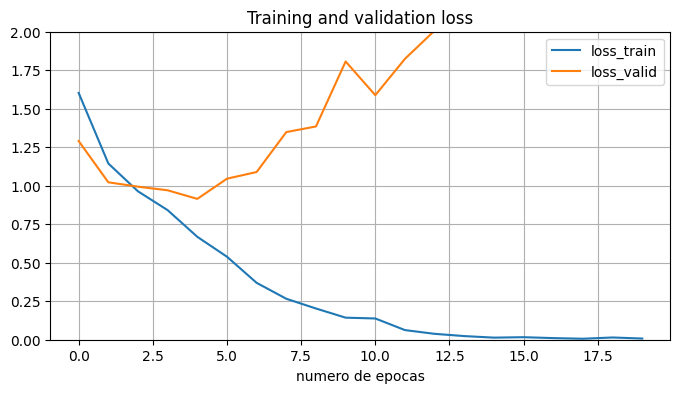

In [27]:
import pandas as pd

pd.DataFrame({'loss_train': history.history['loss'],
              'loss_valid': history.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

Como podemos ver en el gráfico claramente se produce un gran sobreajuste en el modelo.

Este puede ser producido por el aprendizaje por parte de la red de ruido y detalles innecesarios, así como por la limiitación del propio dataset en cuanto a tamaño.

Para eliminar este problema emplearemos a continuación técnicas de reducción del sobreajuste como data augmentation y dropout.


Para ello comenzaremos creando un segundo modelo exactamente igual.

In [28]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape=(150,150,3), padding = 'same',
                              activation = 'relu', name = 'Conv1'))
model2.add(keras.layers.MaxPooling2D(strides=(2,2)))

model2.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'Conv2'))
model2.add(keras.layers.MaxPooling2D(strides=(2,2)))

model2.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'Conv3'))
model2.add(keras.layers.MaxPooling2D(strides=(2,2)))

model2.add(keras.layers.Flatten())

model2.add(keras.layers.Dense(units=512, activation='relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(units=5, activation='softmax'))

In [29]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 Conv2 (Conv2D)              (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 Conv3 (Conv2D)              (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 18, 18, 96)      

Para el problema aplicaremos unas transofrmaciones como son:

    * Rotaciones
    * Desplazamientos
    * Flips
    * Zooms

Ya que, por la naturaleza del problema, estas transformaciones no influirán a la hora de reconocer si es una flor o no, pero evitará el sobreajuste en cierta medida ya que la red reconocerá características generales, dejando de "copiar".

Para ello definiremos un nuevo DataGenerator:

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [31]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150,150),
                                                    batch_size=100,
                                                    class_mode='sparse')

Found 2935 images belonging to 5 classes.


Ejecutemos el nuevo modelo:

In [32]:
optim = keras.optimizers.Adam(learning_rate=0.001)

model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

In [33]:
history2 = model2.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
30/30 [==============================] - 24s 732ms/step - loss: 1.4418 - acc: 0.3608 - val_loss: 1.2911 - val_acc: 0.4340
Epoch 2/20
30/30 [==============================] - 22s 725ms/step - loss: 1.1921 - acc: 0.5060 - val_loss: 1.1610 - val_acc: 0.5347
Epoch 3/20
30/30 [==============================] - 22s 742ms/step - loss: 1.0945 - acc: 0.5612 - val_loss: 1.0166 - val_acc: 0.5932
Epoch 4/20
30/30 [==============================] - 21s 686ms/step - loss: 0.9882 - acc: 0.6027 - val_loss: 0.8969 - val_acc: 0.6395
Epoch 5/20
30/30 [==============================] - 22s 729ms/step - loss: 0.9518 - acc: 0.6290 - val_loss: 1.0522 - val_acc: 0.6041
Epoch 6/20
30/30 [==============================] - 22s 729ms/step - loss: 0.9069 - acc: 0.6477 - val_loss: 0.8533 - val_acc: 0.6639
Epoch 7/20
30/30 [==============================] - 22s 734ms/step - loss: 0.8549 - acc: 0.6767 - val_loss: 0.8228 - val_acc: 0.6639
Epoch 8/20
30/30 [==============================] - 22s 711ms/step - 

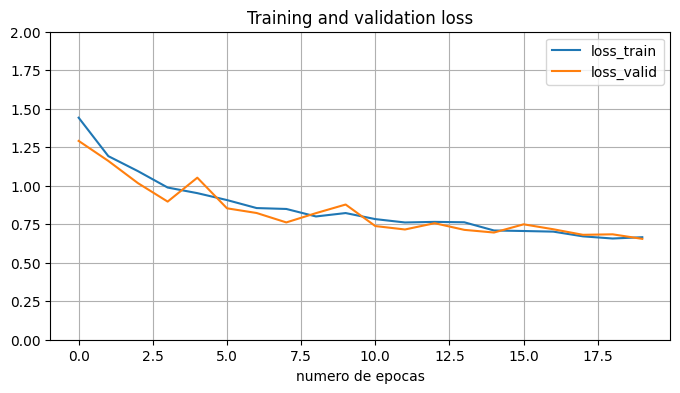

In [34]:
pd.DataFrame({'loss_train': history2.history['loss'],
              'loss_valid': history2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Training and validation loss');

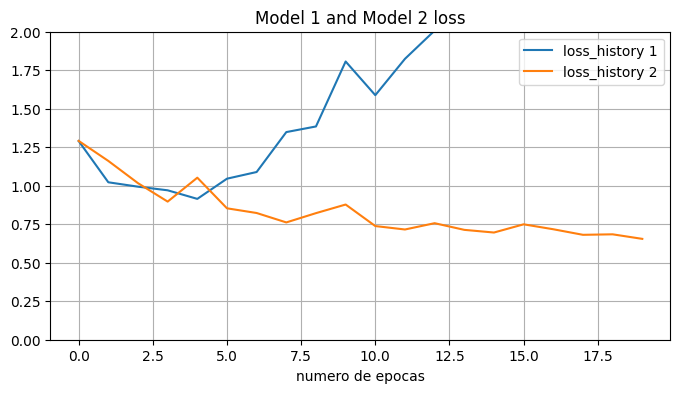

In [35]:
pd.DataFrame({'loss_history 1': history.history['val_loss'],
              'loss_history 2': history2.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Model 1 and Model 2 loss');

Como vemos en las gráficas con estas medidas controlamos el loss y mejoramos el accuracy.

En este problema usando CNNs diseñadas y entrenadas por nosotros aparece una barrera entorno al 75-80% de precisión del modelo sobre validación.

El siguiente paso para mejorar esto es implementar la llamada técnica de Transfer Learning, donde cogeremos una red preentrenada con una gran cantidad de datos y categorías.

En el trbajo original nos daban a "elegir" entre varias redes, en mi casó afronté el problema importanto la red **VGG16** con los pesos preentrenado y sin la parte superior (capas densas) ya que ahí colocaremos las capas densas útiles para nuestro problema de 5 categorías.

In [36]:
#Comenzamos importando el modelo.

from keras.applications import VGG16

vgg_model = VGG16(weights= 'imagenet', include_top= False, input_shape= (224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [37]:
#A continuación procedemos con el Fine-Tuning
for layer in vgg_model.layers[:16]:
  layer.trainable = False

for i,layer in enumerate(vgg_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [38]:
#A continuación procedemos a completar la red con la capa de Flatten y las capas densas anteriormente descritas:

x = vgg_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units = 4096, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units = 1072, activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(units = 5, activation = 'softmax')(x)

model3 = keras.Model(vgg_model.input, output)

In [39]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Esta vez no hay que indicarle rescale al DataGenerator, ya que las preprocesaremos igual que cuando se entrenó VGG.

In [40]:
from keras.applications.vgg16 import preprocess_input
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [41]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=100,
                                                    class_mode='sparse')
validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(224,224),
                                                    batch_size=100,
                                                    class_mode='sparse')

Found 2935 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


A la hora de entrenar un modelo ya preentrenado es típico bajar el learning rate.

In [42]:
optim = keras.optimizers.Adam(learning_rate=0.0001)

model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optim,
              metrics=['acc'])

In [43]:
history3 = model3.fit(train_generator, epochs=15, validation_data=validation_generator)

Epoch 1/15
30/30 [==============================] - 69s 2s/step - loss: 4.7378 - acc: 0.4709 - val_loss: 0.9369 - val_acc: 0.6707
Epoch 2/15
30/30 [==============================] - 56s 2s/step - loss: 1.0327 - acc: 0.6303 - val_loss: 0.7381 - val_acc: 0.7592
Epoch 3/15
30/30 [==============================] - 53s 2s/step - loss: 0.7604 - acc: 0.7468 - val_loss: 0.5479 - val_acc: 0.8313
Epoch 4/15
30/30 [==============================] - 53s 2s/step - loss: 0.5816 - acc: 0.7993 - val_loss: 0.5351 - val_acc: 0.8544
Epoch 5/15
30/30 [==============================] - 50s 2s/step - loss: 0.4732 - acc: 0.8399 - val_loss: 0.5287 - val_acc: 0.8558
Epoch 6/15
30/30 [==============================] - 51s 2s/step - loss: 0.4421 - acc: 0.8480 - val_loss: 0.4509 - val_acc: 0.8762
Epoch 7/15
30/30 [==============================] - 48s 2s/step - loss: 0.4007 - acc: 0.8542 - val_loss: 0.4497 - val_acc: 0.8884
Epoch 8/15
30/30 [==============================] - 47s 2s/step - loss: 0.3527 - acc: 0.87

En el trabajo original tengo una explicación completa de la estructura de esta red VGG.

Pero de esta red podemos destacar:

* Su simplicidad que facilita su comprensión e implementación.
* El uso de kernels pequeños (3x3) lo que permite aprender características más locales y complejas.
* La reducción de tamaño solo por parte de las capas de MaxPooling (2,2).
* El incremento del número de filtros con razón 2.



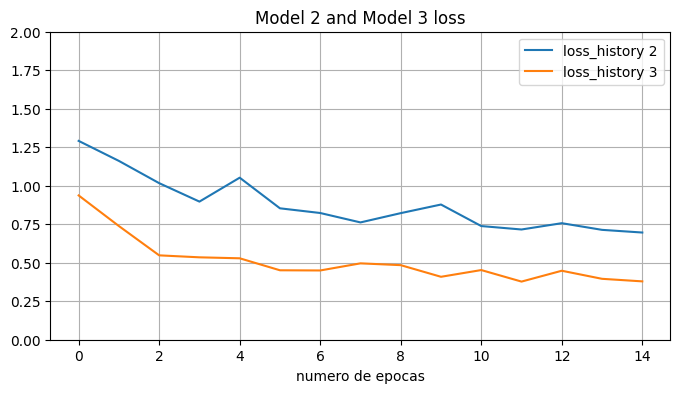

In [45]:
pd.DataFrame({'loss_history 2': history2.history['val_loss'][:15],
              'loss_history 3': history3.history['val_loss']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,2)
plt.xlabel('numero de epocas')
plt.title('Model 2 and Model 3 loss');

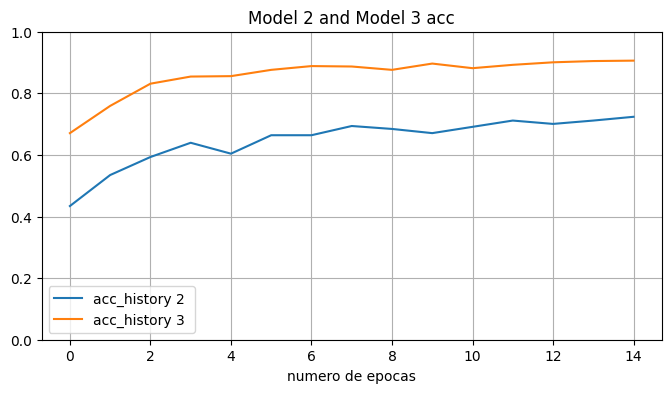

In [46]:
pd.DataFrame({'acc_history 2 ': history2.history['val_acc'][:15],
              'acc_history 3': history3.history['val_acc']}).plot(figsize=(8,4))

plt.grid(True)
plt.ylim(0,1)
plt.xlabel('numero de epocas')
plt.title('Model 2 and Model 3 acc');

Por último y, como era de prever, observamos que el rendimiento con Transfer-Learning aumenta hasta un 90% sobre validación.

Con esto podemos darnos por satisfechos con este modelo para el problema de clasificación de flores.

Gracias por leer.